In [1]:
import datasets
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


/users/shaox7/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds_compinfo = load_dataset("v1ctor10/BERT_SBERT_PALM_embeddingsSAE")
df_compinfo = ds_compinfo['train'].to_pandas()

In [3]:
df_compinfo["year"] = df_compinfo["year"].astype(int)
df_compinfo = df_compinfo[~df_compinfo['year'].isin([1993, 1994, 1995])]
df_compinfo = df_compinfo.sort_values(by=['year'], ascending=True)
df_compinfo = df_compinfo.reset_index(drop=True)
df_compinfo = df_compinfo.dropna(subset=['sic_code'])
print(f"Number of rows after dropping missing sic_code: {len(df_compinfo)}")
# Define a function to classify SIC codes into industries based on the first two digits
def classify_sic(sic_code):
    # Extract the first two digits of the SIC code
    first_two_digits = int(str(sic_code)[:2])
    
    # Map to industry categories
    if 1 <= first_two_digits <= 9:
        return 'Agriculture, Forestry, And Fishing'
    elif 10 <= first_two_digits <= 14:
        return 'Mining'
    elif 15 <= first_two_digits <= 17:
        return 'Construction'
    elif 20 <= first_two_digits <= 39:
        return 'Manufacturing'
    elif 40 <= first_two_digits <= 49:
        return 'Transportation, Communications, Electric, Gas, And Sanitary Services'
    elif 50 <= first_two_digits <= 51:
        return 'Wholesale Trade'
    elif 52 <= first_two_digits <= 59:
        return 'Retail Trade'
    elif 60 <= first_two_digits <= 67:
        return 'Finance, Insurance, And Real Estate'
    elif 70 <= first_two_digits <= 89:
        return 'Services'
    elif 90 <= first_two_digits <= 99:
        return 'Public Administration'
    else:
        return 'Unknown'

# Apply the classification to the SIC codes in the dataset
df_compinfo['industry_classification'] = df_compinfo['sic_code'].apply(classify_sic)

df_compinfo = df_compinfo[["year", "sic_code", "cik", "ticker", "industry_classification", "__index_level_0__", "PALMGECKO-embedding"]]
df_compinfo


Number of rows after dropping missing sic_code: 26769


,year,sic_code,cik,ticker,industry_classification,__index_level_0__,PALMGECKO-embedding
0,1996,6021,875357,[BOKF],"Finance, Insurance, And Real Estate",1455,"[0.028801165521144867, -0.004072049167007208, ..."
1,1996,7372,935036,[ACIW],Services,1456,"[0.04355491325259209, -0.041682351380586624, -..."
2,1996,2840,80424,[PG],Manufacturing,1457,"[-0.004447496961802244, -0.031077519059181213,..."
3,1996,2320,75288,[OXM],Manufacturing,1458,"[-0.0025872865226119757, -0.06894127279520035,..."
4,1996,3357,913142,[BDC],Manufacturing,1461,"[-0.004585464019328356, -0.04119681566953659, ..."
...,...,...,...,...,...,...,...
26764,2020,7990,1090396,[TBTC],Services,9167,"[0.0076806191354990005, 0.0022095998283475637,..."
26765,2020,6311,59558,"[LNC, LNC-PD]","Finance, Insurance, And Real Estate",9170,"[-0.018874678760766983, -0.033156152814626694,..."
26766,2020,1311,844965,[TTI],Mining,9213,"[0.014242090284824371, -0.02308802679181099, -..."
26767,2020,3537,97216,[TEX],Manufacturing,9217,"[0.022182853892445564, -0.03954493626952171, -..."


In [4]:
import psutil
import os
process = psutil.Process(os.getpid())
print(f"Memory usage before: {process.memory_info().rss / 1024 ** 2:.2f} MB")

Memory usage before: 5128.53 MB


In [ ]:
pairs_ds = load_dataset("v1ctor10/cos_sim_4000pca_exp")
pairs_df = pairs_ds['train'].to_pandas()

In [ ]:
pairs_df["year"]=pairs_df["year"].astype(int)
pairs_df.iloc[30]

In [ ]:
train_data = pairs_df.iloc[20]

In [9]:
df_compinfo.head()

,year,sic_code,cik,ticker,__index_level_0__,PALMGECKO-embedding
0,1996,6021,875357,[BOKF],1455,"[0.028801165521144867, -0.004072049167007208, ..."
1,1996,7372,935036,[ACIW],1456,"[0.04355491325259209, -0.041682351380586624, -..."
2,1996,2840,80424,[PG],1457,"[-0.004447496961802244, -0.031077519059181213,..."
3,1996,2320,75288,[OXM],1458,"[-0.0025872865226119757, -0.06894127279520035,..."
4,1996,3357,913142,[BDC],1461,"[-0.004585464019328356, -0.04119681566953659, ..."


In [11]:
df_compinfo

,year,sic_code,cik,ticker,__index_level_0__,PALMGECKO-embedding
0,1996,6021,875357,[BOKF],1455,"[0.028801165521144867, -0.004072049167007208, ..."
1,1996,7372,935036,[ACIW],1456,"[0.04355491325259209, -0.041682351380586624, -..."
2,1996,2840,80424,[PG],1457,"[-0.004447496961802244, -0.031077519059181213,..."
3,1996,2320,75288,[OXM],1458,"[-0.0025872865226119757, -0.06894127279520035,..."
4,1996,3357,913142,[BDC],1461,"[-0.004585464019328356, -0.04119681566953659, ..."
...,...,...,...,...,...,...
26764,2020,7990,1090396,[TBTC],9167,"[0.0076806191354990005, 0.0022095998283475637,..."
26765,2020,6311,59558,"[LNC, LNC-PD]",9170,"[-0.018874678760766983, -0.033156152814626694,..."
26766,2020,1311,844965,[TTI],9213,"[0.014242090284824371, -0.02308802679181099, -..."
26767,2020,3537,97216,[TEX],9217,"[0.022182853892445564, -0.03954493626952171, -..."


# used rbf instead of (nearest_neighbors)

Use Cases:

When global similarities (instead of just local) matter.
Suitable for compact, Gaussian-like clusters or when the clusters are not well-separated locally.
Advantages:

Captures global structure.
Does not rely on choosing the number of neighbors, which can sometimes be hard to tune.
Disadvantages:

Can be computationally expensive for large datasets because the matrix is dense.
Sensitive to the choice of the gamma parameter in the RBF kernel 

In [13]:
df_compinfo

,year,sic_code,cik,ticker,__index_level_0__,PALMGECKO-embedding
0,1996,6021,875357,[BOKF],1455,"[0.028801165521144867, -0.004072049167007208, ..."
1,1996,7372,935036,[ACIW],1456,"[0.04355491325259209, -0.041682351380586624, -..."
2,1996,2840,80424,[PG],1457,"[-0.004447496961802244, -0.031077519059181213,..."
3,1996,2320,75288,[OXM],1458,"[-0.0025872865226119757, -0.06894127279520035,..."
4,1996,3357,913142,[BDC],1461,"[-0.004585464019328356, -0.04119681566953659, ..."
...,...,...,...,...,...,...
26764,2020,7990,1090396,[TBTC],9167,"[0.0076806191354990005, 0.0022095998283475637,..."
26765,2020,6311,59558,"[LNC, LNC-PD]",9170,"[-0.018874678760766983, -0.033156152814626694,..."
26766,2020,1311,844965,[TTI],9213,"[0.014242090284824371, -0.02308802679181099, -..."
26767,2020,3537,97216,[TEX],9217,"[0.022182853892445564, -0.03954493626952171, -..."


In [14]:
embeddings = np.vstack(df_compinfo['PALMGECKO-embedding'].values)
embeddings.shape

(26769, 768)

In [7]:
import pandas as pd
import numpy as np
import optuna
import umap
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from joblib import Parallel, delayed
from tqdm import tqdm

# ====================
# Load and Preprocess Data
# ====================

# Choose which embedding to use; here we use BERT
embeddings = np.vstack(df_compinfo['PALMGECKO-embedding'].values)
embeddings = embeddings.astype('float32')
# Optional: Feature Scaling
# Standardizing embeddings can improve UMAP and clustering performance
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Optimize pairs_df for faster lookup
# Ensure that Company1 < Company2 for consistency
pairs_df[['Company1', 'Company2']] = np.sort(pairs_df[['Company1', 'Company2']], axis=1)
pairs_df.set_index(['Company1', 'Company2'], inplace=True)
pairs_df.sort_index(inplace=True)

# Create a list of company IDs for quick access
company_ids_all = df_compinfo['__index_level_0__'].tolist()

In [9]:
def compute_final_p(clusters, company_ids, pairs_df):
    """
    Compute the average p_bar across all clusters.

    Args:
        clusters (np.ndarray): Cluster labels for each company in the test set.
        company_ids (list): List of company identifiers corresponding to the test set.
        pairs_df (pd.DataFrame): DataFrame containing pairwise correlations indexed by (Company1, Company2).

    Returns:
        float: The final_p metric representing the average cluster correlation.
    """
    cluster_p_bars = []
    unique_clusters = np.unique(clusters)
    
    for cluster_id in unique_clusters:
        cluster_indices = np.where(clusters == cluster_id)[0]
        if len(cluster_indices) < 2:
            continue  # No pairs to compute
        
        # Get company IDs in the cluster
        cluster_company_ids = [company_ids[i] for i in cluster_indices]
        
        # Generate all unique sorted pairs within the cluster
        pairs = combinations(sorted(cluster_company_ids), 2)
        pair_tuples = list(pairs)
        
        if not pair_tuples:
            continue
        
        # Retrieve correlations using the MultiIndex
        try:
            correlations = pairs_df.loc[pair_tuples, 'correlation'].values
        except KeyError:
            # Some pairs might not exist; fetch available correlations
            correlations = []
            for pair in pair_tuples:
                try:
                    corr = pairs_df.loc[pair, 'correlation']
                    correlations.append(corr)
                except KeyError:
                    continue  # Pair not found
        
        # Filter out NaNs
        correlations = [corr for corr in correlations if not pd.isna(corr)]
        
        if correlations:
            p_bar = np.mean(correlations)
            cluster_p_bars.append(p_bar)
    
    if cluster_p_bars:
        final_p = np.mean(cluster_p_bars)
    else:
        final_p = 0.0
    return final_p


In [10]:
def get_temporal_folds(years, n_folds=3):
    """
    Generate temporal folds based on unique sorted years.

    Args:
        years (pd.Series): Series containing the year for each company.
        n_folds (int): Number of temporal folds.

    Returns:
        list of tuples: Each tuple contains (train_indices, test_indices) for a fold.
    """
    unique_years = sorted(years.unique())
    total_years = len(unique_years)
    
    if total_years < (n_folds + 1):
        raise ValueError(f"Not enough unique years ({total_years}) for the number of folds ({n_folds}). "
                         f"Each fold requires at least 1 unique year.")

    fold_size = total_years // (n_folds + 1)  # +1 to ensure no overlap

    # Ensure fold_size is at least 1
    fold_size = max(fold_size, 1)

    folds = []
    for i in range(1, n_folds + 1):
        train_end_year = unique_years[i * fold_size]
        
        # Prevent (i +1)*fold_size from exceeding total_years
        if (i + 1) * fold_size < total_years:
            test_end_year = unique_years[(i + 1) * fold_size]
        else:
            test_end_year = unique_years[-1]
        
        train_indices = df_compinfo[df_compinfo['year'] <= train_end_year].index
        test_indices = df_compinfo[(df_compinfo['year'] > train_end_year) & (df_compinfo['year'] <= test_end_year)].index
        
        # Check if test_indices is empty
        if test_indices.empty:
            logger.warning(f"Fold {i}: Test set is empty. Adjusting test_end_year.")
            # Adjust test_end_year to include at least one year
            if i * fold_size + 1 < total_years:
                test_end_year = unique_years[(i + 1) * fold_size - 1]
                test_indices = df_compinfo[(df_compinfo['year'] > train_end_year) & 
                                           (df_compinfo['year'] <= test_end_year)].index
            else:
                test_end_year = unique_years[-1]
                test_indices = df_compinfo[(df_compinfo['year'] > train_end_year) & 
                                           (df_compinfo['year'] <= test_end_year)].index
        
        folds.append((train_indices, test_indices))
    
    return folds


In [ ]:
import os
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from joblib import Parallel, delayed
import numpy as np
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
import umap


def objective(trial):
    """
    Objective function for Optuna with Temporal Cross-Validation and Parallel Processing.
    """
    # Hyperparameter suggestions for UMAP
    umap_n_components = trial.suggest_int('umap_n_components', 2, 10)
    umap_n_neighbors = trial.suggest_int('umap_n_neighbors', 50, 90)
    umap_min_dist = trial.suggest_float('umap_min_dist', 0.0, 0.6)
    
    # Hyperparameter suggestions for Spectral Clustering
    spectral_n_clusters = trial.suggest_int('spectral_n_clusters', 2, 50)
    spectral_n_neighbors = 5
    
    # Initialize UMAP
    reducer = umap.UMAP(
        n_components=umap_n_components,
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        random_state=42,
        low_memory=True  # Potential speed optimization
    )
    
    def process_fold(train_idx, test_idx):
        # Extract training and testing data
        X_train, X_test = embeddings_scaled[train_idx], embeddings_scaled[test_idx]
        company_ids_train = [company_ids_all[i] for i in train_idx]
        company_ids_test = [company_ids_all[i] for i in test_idx]
        
        # Fit UMAP on training data
        reducer.fit(X_train)
        X_train_reduced = reducer.transform(X_train)
        X_test_reduced = reducer.transform(X_test)
        
        # Create affinity matrix for training data (using all CPUs)
        affinity_matrix = kneighbors_graph(
            X_train_reduced,
            n_neighbors=spectral_n_neighbors,
            mode='connectivity',
            include_self=False,
            n_jobs=8
        ).toarray()
        
        clustering = SpectralClustering(
            n_clusters=spectral_n_clusters,
            affinity='precomputed',
            assign_labels='kmeans',
            random_state=42,
            n_jobs=8  # Use all CPUs
        )
        
        # Fit clustering on train
        clustering.fit(affinity_matrix)
        
        # Test set
        affinity_matrix_test = kneighbors_graph(
            X_test_reduced,
            n_neighbors=spectral_n_neighbors,
            mode='connectivity',
            include_self=False,
            n_jobs=8
        ).toarray()
        
        clustering_test = SpectralClustering(
            n_clusters=spectral_n_clusters,
            affinity='precomputed',
            assign_labels='kmeans',
            random_state=42,
            n_jobs=8
        )
        clustering_test.fit(affinity_matrix_test)
        clusters_test = clustering_test.labels_
        
        # Compute final_p for the test data
        final_p = compute_final_p(clusters_test, company_ids_test, pairs_df)
        return final_p
    
    # Generate temporal folds
    folds = get_temporal_folds(df_compinfo['year'], n_folds=2)
    
    # Parallel processing of folds using all CPUs
    final_p_scores = Parallel(n_jobs=8)(
        delayed(process_fold)(train_idx, test_idx) for train_idx, test_idx in folds
    )
    
    return np.mean(final_p_scores)

def save_study_callback(study, trial):
    """
    Callback to save trial results to CSV after each trial completes.
    """
    trial_data = {
        'number': trial.number,
        'value': trial.value,
        'state': str(trial.state)
    }
    
    for k, v in trial.params.items():
        trial_data[k] = v
    
    df = pd.DataFrame([trial_data])
    filename = "./optuna study results/COPY_PALMGECKO-embedding_study_results(k=5).csv"
    file_exists = os.path.isfile(filename)
    df.to_csv(filename, index=False, mode='a', header=not file_exists)
    print("added")
    display(df)
    print("\n")

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=150, timeout=32400, callbacks=[save_study_callback])

In [ ]:
df_study = study.trials_dataframe()
df_study

# Get final results

## helper functions:

In [11]:
def get_joined(TOJOINDF):
    # Initialize the result list
    year_joined_df_data = []
    
    # Iterate over each year in the DataFrames
    for index, row in year_cluster_df.iterrows():
        year = row['year']
        clusters1 = row['clusters']  # Clusters from year_cluster_df
    
        # Get the corresponding clusters for the same year from year_SIC_cluster_df
        sic_row = TOJOINDF[TOJOINDF['year'] == year]
        if sic_row.empty:
            continue  # Skip if no matching year in SIC clusters
        clusters2 = sic_row.iloc[0]['clusters']  # Extract the SIC clusters dictionary
    
        # Build a mapping from company IDs to SIC cluster IDs
        company_sic_cluster_dict = {}
        for sic_cluster_id, sic_companies in clusters2.items():
            for company_id in sic_companies:
                company_sic_cluster_dict[company_id] = sic_cluster_id
    
        # For each cluster in clusters1, check if all companies have the same SIC cluster ID
        joined_clusters = {}
        for cluster_id, companies in clusters1.items():
            sic_cluster_ids = set()
            for company_id in companies:
                if company_id in company_sic_cluster_dict:
                    sic_cluster_ids.add(company_sic_cluster_dict[company_id])
                else:
                    # Company not found in SIC clusters
                    sic_cluster_ids.add(None)
            # If all companies have the same SIC cluster ID (and not None)
            if len(sic_cluster_ids) == 1 and None not in sic_cluster_ids:
                # Include this cluster in joined_clusters
                joined_clusters[cluster_id] = companies
    
        # Only include clusters with non-empty joined_clusters
        if joined_clusters:
            year_joined_df_data.append({'year': year, 'clusters': joined_clusters})
    
    # Convert the result list to a DataFrame
    year_joined_df = pd.DataFrame(year_joined_df_data)
    return year_joined_df

def create_cluster_dfs(df_compinfo, year_cluster_df):
    """
    Create SIC and Industry cluster DataFrames for each year.
    """
    year_SIC_cluster_df = []
    year_Industry_cluster_df = []

    for year in tqdm(sorted(df_compinfo['year'].unique()), desc="Generating Cluster DataFrames"):
        # Filter companies for the year
        year_data = df_compinfo[df_compinfo['year'] == year]

        # SIC clusters
        sic_clusters = year_data.groupby('sic_code')['__index_level_0__'].apply(list).to_dict()
        year_SIC_cluster_df.append({'year': year, 'clusters': sic_clusters})

        # Industry clusters
        industry_clusters = year_data.groupby('industry_classification')['__index_level_0__'].apply(list).to_dict()
        year_Industry_cluster_df.append({'year': year, 'clusters': industry_clusters})

    return pd.DataFrame(year_SIC_cluster_df), pd.DataFrame(year_Industry_cluster_df)


def calculate_avg_correlation(TO_ANALYSE_DF, cluster_df, cluster_type):
    """
    Calculate the mean correlation for each cluster type per year.

    Parameters:
    - TO_ANALYSE_DF (pd.DataFrame): Original DataFrame containing 'year', 'Company1', 'Company2', and 'correlation'.
    - cluster_df (pd.DataFrame): DataFrame with 'year' and 'clusters' columns.
    - cluster_type (str): Description of the cluster type for labeling.

    Returns:
    - pd.DataFrame: DataFrame with 'year' and average correlation for the cluster type.
    """
    avg_correlations = []
    
    for _, row in tqdm(cluster_df.iterrows(), desc=f"Calculating Stats for {cluster_type}", total=len(cluster_df)):
        year = row['year']
        clusters = row['clusters']
        year_data = TO_ANALYSE_DF[TO_ANALYSE_DF['year'] == year]
        cluster_stats = []
        
        for cluster_id, companies in clusters.items():
            if len(companies) <= 1:  # Skip clusters with only 1 company
                continue

            # Get all pairs of companies within the cluster
            cluster_pairs = year_data[
                (year_data['Company1'].isin(companies) & year_data['Company2'].isin(companies))
            ]
            # Calculate statistics for the cluster
            if not cluster_pairs.empty:
                try:
                    correlations = cluster_pairs['correlation']
                except KeyError:
                    # Handle alternative column name if 'correlation' doesn't exist
                    correlations = cluster_pairs['ActualCorrelation']
                cluster_stats.append(correlations.mean())

        # Aggregate statistics across clusters for the year
        if cluster_stats:
            avg_correlations.append({
                'year': year,
                f'{cluster_type}AvgCorrelation': sum(cluster_stats) / len(cluster_stats)
            })
        else:
            avg_correlations.append({
                'year': year,
                f'{cluster_type}AvgCorrelation': np.nan
            })
    
    return pd.DataFrame(avg_correlations)


In [12]:
# year_SIC_cluster_df.to_pickle("year_SIC_cluster_mapping.pkl")
# year_Industry_cluster_df.to_pickle("year_Industry_cluster_mapping.pkl")
year_SIC_cluster_df = pd.read_pickle("year_SIC_cluster_mapping.pkl")
year_Industry_cluster_df = pd.read_pickle("year_Industry_cluster_mapping.pkl")
# sic_avg_corr.to_csv("sic_avg_corr.csv", index=False)
# industry_avg_corr.to_csv("industry_avg_corr.csv", index=False)

sic_avg_corr = pd.read_csv("sic_avg_corr.csv")
industry_avg_corr = pd.read_csv("industry_avg_corr.csv")
sic_p = sic_avg_corr.mean()[1]
ind_p = industry_avg_corr.mean()[1]
pop_p = pairs_df["correlation"].mean()
print(f"sic: {sic_p}, industry: {ind_p}, population: {pop_p}")

sic: 0.23108531998655252, industry: 0.1868374834363482, population: 0.1608652755353452


In [13]:
cluster_name = "PaLM-gecko"
threshold = "best-optuna"

In [14]:
import pandas as pd
import numpy as np
import umap
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm

# ============================================
# Chosen parameters (example - replace with your best found parameters)
# ============================================
umap_n_components = 6     # e.g. best found
umap_n_neighbors = 40     # e.g. best found
umap_min_dist = 0.11980426929501584       # e.g. best found
spectral_n_clusters = 27   # e.g. best found
spectral_n_neighbors = 5

# ============================================
# Cluster Each Year
# ============================================

# Get all years sorted
unique_years = sorted(df_compinfo['year'].unique())

all_rows = []

# Add tqdm to the loop for progress tracking
for yr in tqdm(unique_years, desc="Processing Years"):
    # Filter indices for this specific year
    idx = df_compinfo.index[df_compinfo['year'] == yr]
    X_yr = embeddings_scaled[idx]

    # Fit and transform data using UMAP for this year
    reducer = umap.UMAP(
        n_components=umap_n_components,
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        random_state=42,
        low_memory=True
    )
    X_yr_reduced = reducer.fit_transform(X_yr)

    # Create an affinity matrix for spectral clustering
    affinity_matrix = kneighbors_graph(
        X_yr_reduced,
        n_neighbors=spectral_n_neighbors,
        mode='connectivity',
        include_self=False,
        n_jobs=-1
    ).toarray()

    # Perform spectral clustering on this year's data
    clustering = SpectralClustering(
        n_clusters=spectral_n_clusters,
        affinity='precomputed',
        assign_labels='kmeans',
        random_state=42,
        n_jobs=-1
    )
    labels = clustering.fit_predict(affinity_matrix)

    # Create a dictionary {cluster_label: [list_of_company_ids]}
    clusters_dict = {}
    # company_ids_this_year: the IDs for companies in this year's slice
    company_ids_this_year = df_compinfo.loc[idx, '__index_level_0__'].values
    for lbl, cid in zip(labels, company_ids_this_year):
        clusters_dict.setdefault(lbl, []).append(cid)

    # Append the result for this year
    all_rows.append({'year': yr, 'clusters': clusters_dict})

# Create a dataframe with columns year and clusters
df_clusters = pd.DataFrame(all_rows, columns=['year', 'clusters'])

# df_clusters will look like:
#    year                                             clusters
# 0  1996  {0: [1171], 1: [1172,1176,1177,1180,1183,...}, ...
# 1  1997  {0: [2072], 1: [2073,2075,2076,2077,2083,...}, ...
df_clusters



rocessing Years: 100%|██████████| 25/25 [01:25<00:00,  3.44s/it]

,year,clusters
0,1996,"{23: [1455, 1442, 1440, 1210, 1563, 1693, 1760..."
1,1997,"{11: [2547, 2553, 2579, 2816, 2896, 2891, 2493..."
2,1998,"{5: [3432, 3434, 3473, 16150, 3609, 3644, 3490..."
3,1999,"{22: [21822, 21995, 21895, 10150, 16248, 16288..."
4,2000,"{4: [10165, 10172, 10214, 16323, 22051, 22058,..."
5,2001,"{20: [23841, 23849, 24378, 24307, 16495, 24318..."
6,2002,"{17: [25390, 25408, 25317, 25320, 25023, 25072..."
7,2003,"{10: [26855, 26892, 26879, 10768, 10709, 10682..."
8,2004,"{20: [27069, 26960, 27272, 27290, 27861, 27876..."
9,2005,"{10: [29602, 28298, 28267, 28271, 28437, 28401..."


In [ ]:
pairs_ds = load_dataset("v1ctor10/cos_sim_4000pca_exp")
pairs_df = pairs_ds['train'].to_pandas()

In [16]:
year_cluster_df = df_clusters
TO_ANALYSE_DF = pairs_df

TO_ANALYSE_DF['year'] = TO_ANALYSE_DF['year'].astype(int)
year_cluster_df["year"] = year_cluster_df["year"].astype(int)

# Create SIC and Industry cluster DataFrames
year_cluster_df['clusters'] = year_cluster_df['clusters'].apply(lambda x: {k: v for k, v in x.items() if k != -1})
year_SIC_cluster_df, year_Industry_cluster_df = create_cluster_dfs(df_compinfo, TO_ANALYSE_DF)

year_cluster_df["year"] = year_cluster_df["year"].astype(int)
year_SIC_cluster_df["year"]= year_SIC_cluster_df["year"].astype(int)
year_Industry_cluster_df["year"]= year_Industry_cluster_df["year"].astype(int)

TO_ANALYSE_DF['year'] = TO_ANALYSE_DF['year'].astype(int)
year_cluster_df["year"] = year_cluster_df["year"].astype(int)
year_SIC_cluster_df["year"]= year_SIC_cluster_df["year"].astype(int)
year_Industry_cluster_df["year"]= year_Industry_cluster_df["year"].astype(int)

year_Industry_joined_df = get_joined(year_Industry_cluster_df)
year_SIC_joined_df = get_joined(year_SIC_cluster_df)



# Calculate average correlations for custom clusters, SIC, and Industry

try:
    year_Industry_joined_df["year"] = year_Industry_joined_df["year"].astype(int)
    Industry_joined_cluster_avg_corr = calculate_avg_correlation(TO_ANALYSE_DF, year_Industry_joined_df, "IndustryJoinedCluster")

except:
    pass
try:
    year_SIC_joined_df["year"] = year_SIC_joined_df["year"].astype(int)
    SIC_joined_cluster_avg_corr = calculate_avg_correlation(TO_ANALYSE_DF, year_SIC_joined_df, "SICJoinedCluster")
except:
    pass
    
custom_cluster_avg_corr = calculate_avg_correlation(TO_ANALYSE_DF, year_cluster_df, "CustomCluster")
# sic_avg_corr = calculate_avg_correlation(pairs_df, year_SIC_cluster_df, "SIC")
# industry_avg_corr = calculate_avg_correlation(pairs_df, year_Industry_cluster_df, "Industry")

final_results = pd.merge(custom_cluster_avg_corr, sic_avg_corr, on='year', how='outer')
final_results = pd.merge(final_results, industry_avg_corr, on='year', how='outer')
try:
    final_results = pd.merge(final_results, Industry_joined_cluster_avg_corr, on='year', how='outer')
except:
    pass
try:
    final_results = pd.merge(final_results, SIC_joined_cluster_avg_corr, on='year', how='outer')
except:
    pass


temp_results = final_results





alculating Stats for CustomCluster: 100%|██████████| 25/25 [00:03<00:00,  7.01it/s]5it/s]

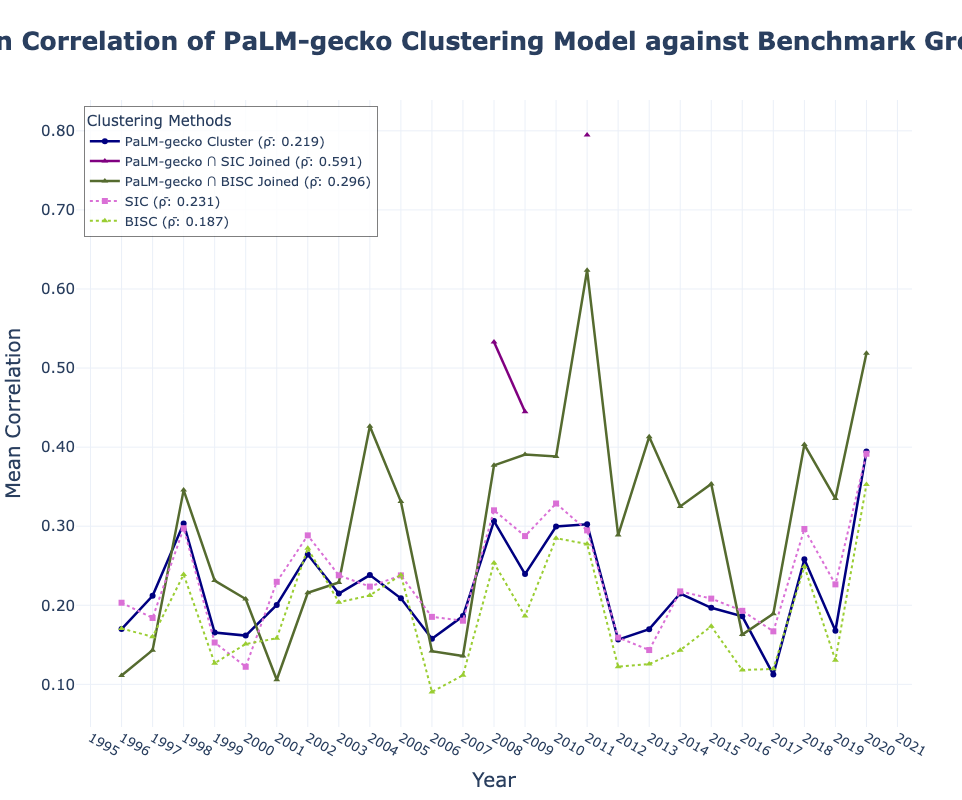

In [23]:
import plotly.graph_objects as go
import kaleido

import plotly.graph_objects as go

# Initialize the figure
fig = go.Figure()

# Add traces for each cluster type
fig.add_trace(go.Scatter(
    x=temp_results["year"],
    y=temp_results["CustomClusterAvgCorrelation"],
    mode='lines+markers',
    name=f"{cluster_name} Cluster (ρ̄: {temp_results['CustomClusterAvgCorrelation'].mean():.3f})",
    line=dict(color='navy', width=2.5, dash='solid'),
    marker=dict(symbol='circle', size=6)
))

# Add Feature ∩ SIC Joined
if "SICJoinedClusterAvgCorrelation" in temp_results:
    fig.add_trace(go.Scatter(
        x=temp_results["year"],
        y=temp_results["SICJoinedClusterAvgCorrelation"],
        mode='lines+markers',
        name=f"{cluster_name} ∩ SIC Joined (ρ̄: {temp_results['SICJoinedClusterAvgCorrelation'].mean():.3f})",
        line=dict(color='purple', width=2.5, dash='solid'),
        marker=dict(symbol='triangle-up', size=6)
    ))

# Add Feature ∩ BISC Joined
if "IndustryJoinedClusterAvgCorrelation" in temp_results:
    fig.add_trace(go.Scatter(
        x=temp_results["year"],
        y=temp_results["IndustryJoinedClusterAvgCorrelation"],
        mode='lines+markers',
        name=f"{cluster_name} ∩ BISC Joined (ρ̄: {temp_results['IndustryJoinedClusterAvgCorrelation'].mean():.3f})",
        line=dict(color='darkolivegreen', width=2.5, dash='solid'),
        marker=dict(symbol='triangle-up', size=6)
    ))

# Add SIC
fig.add_trace(go.Scatter(
    x=temp_results["year"],
    y=temp_results["SICAvgCorrelation"],
    mode='lines+markers',
    name=f"SIC (ρ̄: {temp_results['SICAvgCorrelation'].mean():.3f})",
    line=dict(color='orchid', width=2, dash='dot'),
    marker=dict(symbol='square', size=6)
))

# Add BISC
fig.add_trace(go.Scatter(
    x=temp_results["year"],
    y=temp_results["IndustryAvgCorrelation"],
    mode='lines+markers',
    name=f"BISC (ρ̄: {temp_results['IndustryAvgCorrelation'].mean():.3f})",
    line=dict(color='yellowgreen', width=2, dash='dot'),
    marker=dict(symbol='triangle-up', size=6)
))

fig.update_layout(
    title=dict(
        text=f"<b>Mean Correlation of {cluster_name} Clustering Model against Benchmark Groups</b><br>",
        x=0.5,
        xanchor='center',
        font=dict(size=25)
    ),
    xaxis=dict(
        title="Year",
        tickmode='linear',
        dtick=1,
        title_font=dict(size=20),
        tickfont=dict(size=13)
    ),
    yaxis=dict(
        title="Mean Correlation",
        title_font=dict(size=20),
        tickfont=dict(size=15),
        tickformat=".2f"
    ),
    legend=dict(
        title="Clustering Methods",
        font=dict(size=13),
        title_font=dict(size=15),
        x=0.01,
        y=0.99,
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="black",
        borderwidth=0.5
    ),
    template="plotly_white",
    margin=dict(l=50, r=50, t=100, b=50),
    width=1300,  # Adjust width
    height=800  # Adjust height
)

# Export high-resolution image
fig.write_image(f'{cluster_name}_final_plot_resized.png', scale=2)

# Show the figure
fig.show()



In [24]:
year_cluster_df

,year,clusters
0,1996,"{23: [1455, 1442, 1440, 1210, 1563, 1693, 1760..."
1,1997,"{11: [2547, 2553, 2579, 2816, 2896, 2891, 2493..."
2,1998,"{5: [3432, 3434, 3473, 16150, 3609, 3644, 3490..."
3,1999,"{22: [21822, 21995, 21895, 10150, 16248, 16288..."
4,2000,"{4: [10165, 10172, 10214, 16323, 22051, 22058,..."
5,2001,"{20: [23841, 23849, 24378, 24307, 16495, 24318..."
6,2002,"{17: [25390, 25408, 25317, 25320, 25023, 25072..."
7,2003,"{10: [26855, 26892, 26879, 10768, 10709, 10682..."
8,2004,"{20: [27069, 26960, 27272, 27290, 27861, 27876..."
9,2005,"{10: [29602, 28298, 28267, 28271, 28437, 28401..."


In [25]:
cluster_name

'PaLM-gecko'

In [26]:
year_cluster_df.to_pickle(f"./Final Results/year_cluster_df{cluster_name}.pkl")

year_SIC_joined_df.to_pickle(f"./Final Results/year_industry_joined_df{cluster_name}.pkl")

year_Industry_joined_df.to_pickle(f"./Final Results/year_sic_joined_cluster_df{cluster_name}.pkl")